# Dogs vs Cats classification using simple linear regression
By: Andrés M. Castillo

Warning!! Real life is not thaat simple. I've selected the images to get this little introductory example working for you.

Objective: Build a classification model that predicts the animal(cat or dog) in the picture. The purpose of this example is to illustrate the general machine learning setup and feature engeeniering process. For the ones who don't not know, bellow I show a picture of a real cat and a real dog

Cat | Dog
- | - 
<img src="data/cats/cat0.jpeg"> |  <img src="data/dogs/dog0.jpeg">

 Now lets start to see how many pictures we have and what is its format. But before let's install some libraries that we'll need during this example
 


In [366]:
# import the necessary packages
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import argparse
import cv2
import glob
from pandas import DataFrame
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



In [1]:
!ls -alh data/*/*

-rw-r--r--@ 1 acastillo  staff   6.4K Aug 15 18:03 data/cats/cat0.jpeg
-rw-r--r--@ 1 acastillo  staff   6.8K Aug 15 17:55 data/cats/cat1.jpeg
-rw-r--r--@ 1 acastillo  staff    12K Aug 15 17:55 data/cats/cat2.jpeg
-rw-r--r--@ 1 acastillo  staff   5.3K Aug 15 17:55 data/cats/cat3.jpeg
-rw-r--r--@ 1 acastillo  staff   5.7K Aug 15 17:55 data/cats/cat4.jpeg
-rw-r--r--@ 1 acastillo  staff   5.2K Aug 15 17:56 data/cats/cat5.jpeg
-rw-r--r--@ 1 acastillo  staff   5.1K Aug 15 17:56 data/cats/cat6.jpeg
-rw-r--r--@ 1 acastillo  staff   9.3K Aug 15 18:03 data/cats/cat7.jpeg
-rw-r--r--@ 1 acastillo  staff   7.6K Aug 15 18:03 data/cats/cat8.jpeg
-rw-r--r--@ 1 acastillo  staff   7.3K Aug 15 18:03 data/cats/cat9.jpeg
-rw-r--r--@ 1 acastillo  staff   6.4K Aug 15 18:02 data/dogs/dog0.jpeg
-rw-r--r--@ 1 acastillo  staff   7.7K Aug 15 17:59 data/dogs/dog1.jpeg
-rw-r--r--@ 1 acastillo  staff    32K Aug 15 17:59 data/dogs/dog2.jpeg
-rw-r--r--@ 1 acastillo  staff   7.7K Aug 15 18:00 data/dogs/dog3.jpeg
-rw-r-

# Data preparation / Preprocessing

In this step we must load our dataset into main memory to start playing with it. 

False. In this little example perhaps that is possible, but in real life you wont be able to load all your images into main memory.
And even if the dataset fits into memory, it is not recomended in any case to do so. In a real image analysis you must scale all the images to fit a given size. For the kind of analysis we are goin to peform, we can extract the features directly.

Let's understand the feature extraction for a single image

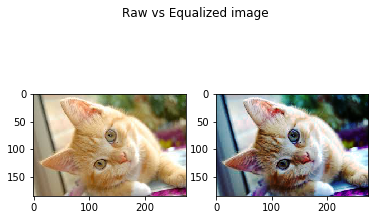

In [504]:

# We will use this function so show our images inside the notebook
def nbImshow(path, title = "Image", splt = plt):
    if type(path) == str:
        # load the image
        image = cv2.imread(path)
    else:
        image = path

    
    #Matplot lib expects img in RGB format but OpenCV provides it in BGR.
    RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    splt.imshow(RGB_im)
    
    if splt == plt:
        splt.title(title)
        splt.show()
 
#Equalize an image. 
def equalizeImage(image, inplace):
    image2 = image
    if inplace == False:
        image2 = image.copy()
    image2[:, :, 0] = cv2.equalizeHist(image[:, :, 0])
    image2[:, :, 1] = cv2.equalizeHist(image[:, :, 1])
    image2[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
    
    return image2

def getFeaturesRGBHist(image, nbinxchanel):
    # grab the image channels, initialize the tuple of colors,
    # the figure and the flattened feature vector
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    features = []

    # loop over the image channels
    for (chan, color) in zip(chans, colors):
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [nbinxchanel], [0, nbinxchanel])
        features.extend(hist)
    
    return features


# load the image and show it
image = cv2.imread("data/cats/cat0.jpeg")#img = cv.imread('messi5.jpg')
image2 = equalizeImage(image, False);

#Plot side by side the original and equalized image
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Raw vs Equalized image')

nbImshow(image, "Example", ax1)
nbImshow(image2, "Equalized", ax2)



Show the difference between raw histograms and equalized histograms. Use use only the Red chanel for this example

(0, 256)

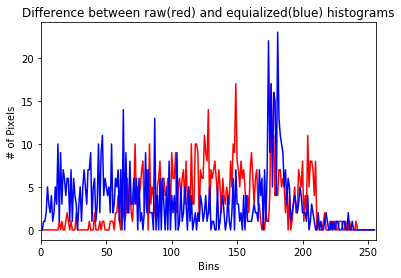

In [505]:
histRGB = cv2.calcHist(image, [0], None, [256], [0, 256])
histEq = cv2.calcHist(image2, [0], None, [256], [0, 256])

plt.figure()
plt.title("Difference between raw(red) and equialized(blue) histograms")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(histRGB, color = "r")
plt.xlim([0, 256])

plt.plot(histEq, color = "b")
plt.xlim([0, 256])

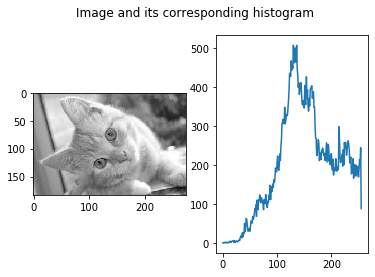

In [506]:
# convert the image to grayscale and create a histogram
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Image and its corresponding histogram')
nbImshow(gray, "Gray scale image", ax1)

hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
ax2.plot(hist)


Now, lets compute a flattened color histogram

flattened feature vector size:  99


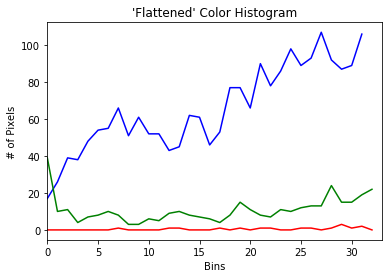

In [508]:
nbinxchanel = 33
features = getFeaturesRGBHist(image, nbinxchanel)

plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")

plt.plot(features[1:nbinxchanel], color = "b")
plt.xlim([0, nbinxchanel])

plt.plot(features[nbinxchanel: nbinxchanel * 2], color = "g")
plt.xlim([0, nbinxchanel])

plt.plot(features[nbinxchanel * 2: nbinxchanel * 3], color = "r")
plt.xlim([0, nbinxchanel])

# here we are simply showing the dimensionality of the
# flattened color histogram 256 bins for each channel
# x 3 channels = 768 total values -- in practice, we would
# normally not use 256 bins for each channel, a choice
# between 32-96 bins are normally used, but this tends
# to be application dependent
print ("flattened feature vector size: ", (np.array(features).flatten().shape)[0])

# Create the dataset of features

Read all the images and calculate the features

In [677]:
path = 'data'
nbinxchanel = 256 
df = DataFrame(columns=list(range(0, nbinxchanel * 3 + 1)) )
index = 0

for f in glob.glob(path + "**/*/*", recursive=True):
    print(index, " " ,f)
    image = cv2.imread(f)
    #equalizeImage(image, True);
    features = np.array(getFeaturesRGBHist(image, nbinxchanel))[:,0]
    label = 'Cat'
    if 'dog' in f:
        label = 'Dog'
    df.loc[index] = np.append(features, label)
    index += 1

# Lets change the last column by something we can undestand. Let's call it the class
df.rename(columns={nbinxchanel * 3: 'class'}, inplace=True)

#Let's print the size of the generated dataframe
print ("Data size: ", df.shape)



0   data/dogs/dog15.jpeg
1   data/dogs/dog19.jpeg
2   data/dogs/dog7.jpeg
3   data/dogs/dog6.jpeg
4   data/dogs/dog18.jpeg
5   data/dogs/dog14.jpeg
6   data/dogs/dog1.jpeg
7   data/dogs/dog13.jpeg
8   data/dogs/dog0.jpeg
9   data/dogs/dog3.jpeg
10   data/dogs/dog10.jpeg
11   data/dogs/dog17.jpeg
12   data/dogs/dog5.jpeg
13   data/dogs/dog20.jpeg
14   data/dogs/dog16.jpeg
15   data/dogs/dog8.jpeg
16   data/cats/cat0.jpeg
17   data/cats/cat1.jpeg
18   data/cats/cat15.jpeg
19   data/cats/cat12.jpeg
20   data/cats/cat6.jpeg
21   data/cats/cat7.jpeg
22   data/cats/cat13.jpeg
23   data/cats/cat4.jpeg
24   data/cats/cat10.jpeg
25   data/cats/cat8.jpeg
26   data/cats/cat11.jpeg
27   data/cats/cat5.jpeg
28   data/cats/cat2.jpeg
29   data/cats/cat16.jpeg
30   data/cats/cat17.jpeg
31   data/cats/cat3.jpeg
Data size:  (32, 769)


In [594]:
df.head()

0      1      2      3      4      5      6      7      8      9  ...  \
0  1461.0  113.0  206.0  131.0  257.0  157.0  158.0  170.0  339.0  193.0  ...   
1   187.0  183.0  187.0  221.0  178.0  190.0  222.0  121.0  245.0  121.0  ...   
2  1577.0    0.0  387.0    0.0  416.0    0.0    0.0    0.0    0.0    0.0  ...   
3   995.0  226.0    0.0  298.0    0.0  348.0  335.0    0.0  359.0    0.0  ...   
4   202.0  202.0  208.0  167.0  197.0  219.0  108.0  258.0  143.0  275.0  ...   

     759    760    761    762    763    764    765    766     767 class  
0  153.0  217.0  211.0  198.0  201.0  187.0    0.0    0.0   526.0   Dog  
1  197.0  115.0  277.0  144.0  123.0  244.0  260.0  218.0   105.0   Dog  
2  194.0    0.0  473.0    0.0    0.0    0.0    0.0    0.0  1174.0   Dog  
3  118.0  248.0  161.0  204.0  204.0    0.0    0.0    0.0   766.0   Dog  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  2412.0   Dog  

[5 rows x 769 columns]

# PCA to display the data

Don't run it until you finish the model test

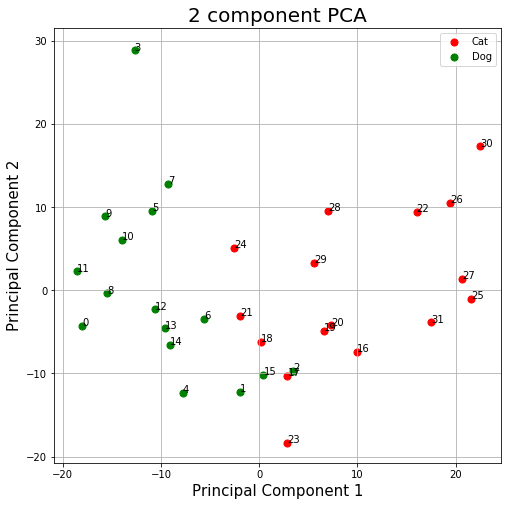

In [678]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = list(range(nbinxchanel * 0, nbinxchanel * 1 ))
features.extend(list(range(nbinxchanel * 2, nbinxchanel * 3 )))
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['class']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components = 4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4'])

finalDf = pd.concat([principalDf, df[['class']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cat', 'Dog']
colors = ['r', 'g']
dims = ['PC1', 'PC2']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, dims[0]]
               , finalDf.loc[indicesToKeep, dims[1]]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

pcx = finalDf.loc[:, dims[0]]
pcy = finalDf.loc[:, dims[1]]

for i, txt in enumerate(range(0, (x.shape)[0])):
    ax.annotate(txt, (pcx[i], pcy[i]))



# Experimetal setup

We split the datset in training and test. We will work with only 4 principal components

In [682]:
from sklearn.model_selection import train_test_split

#train =  finalDf
# Create a new array with the added features: features_two
#features = train[["PC1", "PC2", "PC3", "PC4"]].values
#target = train["class"].values

features = x
target = y

# Split the data into train and test
trainX, testX, trainY, testY = train_test_split(features, target, test_size = 0.2)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(25, 512) (25, 1)
(7, 512) (7, 1)


# Decision trees

Let's seee

In [683]:
#Control overfitting by setting "max_depth" to 10 and "min_samples_split" to 5 : my_tree_two

model1 = tree.DecisionTreeClassifier(max_depth = 15, min_samples_split = 2, random_state = 1)
model1 = model1.fit(trainX, trainY)

#Print the score on the train data
print("On training")
print(model1.score(trainX, trainY))
print(confusion_matrix(model1.predict(trainX), trainY))

#Print the score on the test data
print("\nOn test")
print(model1.score(testX, testY))
print(confusion_matrix(model1.predict(testX), testY))



On training
1.0
[[13  0]
 [ 0 12]]

On test
0.8571428571428571
[[3 1]
 [0 3]]


# Naive Bayes

In [684]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

model2 = gnb.fit(trainX, trainY)

#Print the score on the train data
print("On training")
print(model2.score(trainX, trainY))
print(confusion_matrix(model2.predict(trainX), trainY))

#Print the score on the test data
print("\nOn test")
print(model2.score(testX, testY))
print(confusion_matrix(model2.predict(testX), testY))

# Show the confusion matrix


On training
0.92
[[11  0]
 [ 2 12]]

On test
1.0
[[3 0]
 [0 4]]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
